In [1]:
import pandas as pd
import numpy as np
import pprint as pp
import re, string
import time
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import praw
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import json 
import math
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

# set seaborn settings
sns.set()
plt.rcParams["patch.force_edgecolor"] = True # set lines
plt.style.use('seaborn-darkgrid')


import warnings
warnings.filterwarnings('ignore')

# import credentials and helper functions
import credentials as creds
import helpers as h

C:\Users\Jacky Zhao\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# API AND LIBRARY DOCUMENTATIONS:
# https://praw.readthedocs.io/en/latest/getting_started/
# https://www.reddit.com/dev/api/

## Instantiate Reddit

In [3]:
CLIENT_ID = creds.client_id()
CLIENT_SECRET_KEY = creds.client_secret_key()


r = praw.Reddit(client_id = CLIENT_ID,
                client_secret = CLIENT_SECRET_KEY,
                user_agent = 'RedditorMatch')

## Specify the scraped datasets

Unfortunately, it takes quite some time to retrieve user comments from a particular subreddit. Remember, we're going into a specified subreddit, finding a list of users who posted, and then scraping out every single comment that those users made in the past. In order to remove this bottleneck from my demonstration, I have scraped the comments from users who have posted on r/mizzou. 

In [4]:
scraped_subreddits = ["mizzou"]

## Recommendation engine logic

In [5]:
def find_similar(matrix, index, top_n = 6):
    cosine_similarities = linear_kernel(matrix[index: index + 1], matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

In [6]:
def getDf(subreddit_name):
    filePath = "data/" + subreddit_name + ".csv"
    df = pd.read_csv(filePath, encoding = "ISO-8859-1")
    print("--- Retrieved", len(df), "corpuses for r/", subreddit_name)
    return(df)

In [7]:
def stem(corpus):
    newCorpus = []
    print("------ Stemming the words")
    
    stemmer = PorterStemmer()
    
    for c in corpus:
        try:
            tokens = nltk.word_tokenize(c)
            
            new_tokens = []
            
            for t in tokens:
                try:
                    new_t = stemmer.stem(t)
                    new_tokens.append(new_t)          
                except:
                    print("can't stem the word. moving on...")

            new_c = ' '.join(new_tokens)
            newCorpus.append(new_c)
                
        except:
            print("skipping the comment. something went wrong...")
        
    return(newCorpus)

In [8]:
def createCorpus(your_username, subreddit_name, redditInstance):
    corpus = []    
    corpusDf = getDf(subreddit_name)
    corpusDf["Comments"].apply(lambda row: corpus.append(str(row)))
    
    corpus = stem(corpus)
    
    your_comments = h.getUserComments(your_username, redditInstance)
    your_comments = stem(your_comments)    
    your_comments = " ".join(your_comments)
    
    corpus.insert(0, your_comments)
    return(corpus)

In [9]:
def createTfidfMatrix(corpus):
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    print("--- Creating Tfidf vectorizor...")
    tf = TfidfVectorizer(analyzer = "word", max_df = 0.8, min_df = 0.2, 
                            ngram_range = (1, 3),
                            stop_words = myStopWords)
    
    print("--- Fitting the matrix...")
    matrix = tf.fit_transform(corpus)
    return(matrix)

In [10]:
def findMatches(your_username, subreddit_name, redditInstance):    
    corpus = createCorpus(your_username, subreddit_name, redditInstance)
    matrix = createTfidfMatrix(corpus)
    corpusDf = getDf(subreddit_name)
    
    results = []
    
    for index, score in find_similar(matrix, 0):        
        index = index - 1 # because we prepended our comments onto the corpus, the index number was shifted by 1.
        user = corpusDf.iloc[index, 0]
        results.append(user)
        print("...")
        print("...")
        print("Username:", user, "| Score:", score)
        print("=========================================================")
        
    return(results)

### Example:

In [11]:
# NOTE: I'm displaying the top 6 usernames who are similar. 
# I chose 6 because if the username is contained in my scraped dataset, 
# then that username will always show up as most similar. 
# But we really only care about the top 5 usernames. 

matches = findMatches("Max_W_", scraped_subreddits[0], r)

--- Retrieved 288 corpuses for r/ mizzou
------ Stemming the words
------ Retrieved 1875 comments for: Max_W_
------ Stemming the words
--- Creating Tfidf vectorizor...
--- Fitting the matrix...
--- Retrieved 288 corpuses for r/ mizzou
...
...
Username: Max_W_ | Score: 0.989111748103
...
...
Username: BrettGilpin | Score: 0.566956453617
...
...
Username: EveryTrueSon | Score: 0.555547201932
...
...
Username: Apatches | Score: 0.550465800003
...
...
Username: BransonBombshell | Score: 0.550037564134
...
...
Username: SovreignTripod | Score: 0.545633770494


## Gather user information

In [12]:
def getRedditorInfo(redditor_name, r):
    user = r.redditor(redditor_name)
    top = user.comments.top(limit = 1000)
    hot = user.comments.hot(limit = 1000)
    contro = user.comments.controversial(limit = 1000)
    
    subreddit = []
    comment = []
    created_utc = []
    score = []
    ups = []
    downs = []
    controversiality = []
    flair = []
    gilded = []
    over_18 = []
    link = []
    
    for c in top:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    for c in hot:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    for c in contro:
        subreddit.append(c.subreddit_name_prefixed)
        comment.append(h.cleanText(c.body))
        
        parsed_date = datetime.utcfromtimestamp(c.created_utc)
        year = parsed_date.year
        month = parsed_date.month
        day = parsed_date.day
        
        created_utc.append(parsed_date)
        score.append(c.score)
        ups.append(c.ups)
        downs.append(c.downs)
        controversiality.append(c.controversiality)
        flair.append(c.author_flair_text)
        gilded.append(c.gilded)
        over_18.append(c.over_18)
        link.append(c.link_permalink)
        
    df = pd.DataFrame(subreddit, columns = ["subreddit"])
    df["comment"] = comment
    df["created_utc"] = created_utc
    df["score"] = score
    df["ups"] = ups
    df["downs"] = downs
    df["controversiality"] = controversiality
    df["flair"] = flair
    df["gilded"] = gilded
    df["over_18"] = over_18
    df["link"] = link
    
    df = df.drop_duplicates(subset = ["comment"], keep = "first")    
    print("Retrieved", len(df), "comments for user:", redditor_name)
    return(df)

### Examples

In [13]:
comments1 = getRedditorInfo("Max_W_", r)
comments2 = getRedditorInfo("BrettGilpin", r)

Retrieved 2420 comments for user: Max_W_
Retrieved 2838 comments for user: BrettGilpin


In [14]:
comments1.head()

,subreddit,comment,created_utc,score,ups,downs,controversiality,flair,gilded,over_18,link
0,r/EnoughTrumpSpam,Can we start a petition to keep them private,2017-05-20 02:22:38,8572,8572,0,0,None,1,False,https://www.reddit.com/r/EnoughTrumpSpam/comme...
1,r/AskReddit,Two down one to go,2018-03-09 05:00:25,5548,5548,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/83...
2,r/cringe,Lets applaud her dancers They continued on lik...,2017-01-01 05:24:43,3837,3837,0,0,None,0,False,https://www.reddit.com/r/cringe/comments/5ldm3...
3,r/AskReddit,What do you do when you come across an elephan...,2018-03-09 02:49:12,1970,1970,0,0,None,0,True,https://www.reddit.com/r/AskReddit/comments/83...
4,r/LivestreamFail,She threatened nuclear war with North Korea,2017-11-03 03:50:02,1767,1767,0,0,None,0,False,https://www.reddit.com/r/LivestreamFail/commen...


## Find common subreddits between 2 users

In [15]:
def commonSubreddits(user1, user2, redditInstance):
    
    df1 = getRedditorInfo(user1, redditInstance)
    df2 = getRedditorInfo(user2, redditInstance)
    
    df1 = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)
            
    df2 = df2.groupby(["subreddit"])[['comment']]\
            .count().reset_index()\
            .sort_values(["comment"], ascending = False)
            
    df1 = df1.merge(df2, on = "subreddit", how = "inner")["subreddit"]
    result = np.array(df1)
    
    return(result)

In [16]:
def commonSubredditCounts(user1, user2, redditInstance):
    
    common = commonSubreddits(user1, user2, redditInstance)  
    print(len(common), "common subreddits found...")
    
    df1 = getRedditorInfo(user1, redditInstance)
    df2 = getRedditorInfo(user2, redditInstance)
    
    df1 = df1[df1["subreddit"].isin(common)]
    df2 = df2[df2["subreddit"].isin(common)]
        
    df1Counts = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)\
                .reset_index(drop = True)
                
    df2Counts = df2.groupby(["subreddit"])[['comment']]\
            .count().reset_index()\
            .sort_values(["comment"], ascending = False)\
            .reset_index(drop = True)      
            
    renameCols = ["id", "value"]
            
    df1Counts.columns = renameCols
    df2Counts.columns = renameCols
    
    df1Counts["id"] = df1Counts["id"].str.lower()
    df2Counts["id"] = df2Counts["id"].str.lower()
    
    df1Counts["id"] = df1Counts["id"].str.replace("r/", "")
    df2Counts["id"] = df2Counts["id"].str.replace("r/", "")
    
    df1Counts = df1Counts.sort_values(by = ["id"], ascending = True)
    df2Counts = df2Counts.sort_values(by = ["id"], ascending = True)    
    
                
    return(df1Counts, df2Counts)

In [17]:
def subredditCounts(user, redditInstance):
    df1 = getRedditorInfo(user, redditInstance)
    
    df1Counts = df1.groupby(["subreddit"])[['comment']]\
                .count().reset_index()\
                .sort_values(["comment"], ascending = False)\
                .reset_index(drop = True)
                
    renameCols = ["id", "value"]
    df1Counts.columns = renameCols
    df1Counts["id"] = df1Counts["id"].str.lower()
    df1Counts["id"] = df1Counts["id"].str.replace("r/", "")
    df1Counts = df1Counts.sort_values(by = ["id"], ascending = True)   
    
    return(df1Counts)  

In [18]:
allSubreddits1 = subredditCounts("Max_W_", r)
allSubreddits2 = subredditCounts("PrancingPeach", r)

# Output to CSV files for visualization. 
allSubreddits1.to_csv("frontend/all_sub1.csv", index = False)
allSubreddits2.to_csv("frontend/all_sub2.csv", index = False)

Retrieved 2420 comments for user: Max_W_
Retrieved 2735 comments for user: PrancingPeach


### Examples

In [19]:
one, two = commonSubredditCounts("Max_W_", "BrettGilpin", r)

# Output to CSV files for visualization. 
one.to_csv("frontend/common_sub1.csv", index = False)
two.to_csv("frontend/common_sub2.csv", index = False)

Retrieved 2420 comments for user: Max_W_
Retrieved 2838 comments for user: BrettGilpin
31 common subreddits found...
Retrieved 2420 comments for user: Max_W_
Retrieved 2838 comments for user: BrettGilpin


In [20]:
one.head(20)

,id,value
7,adviceanimals,31
2,android,64
30,askmen,1
0,askreddit,378
21,atheism,2
17,aww,5
20,baseball,2
29,cfb,1
4,funny,43
9,gifs,22


In [21]:
two.head(20)

,id,value
19,adviceanimals,8
7,android,73
1,askmen,151
5,askreddit,82
29,atheism,1
11,aww,39
15,baseball,17
0,cfb,560
27,funny,1
26,gifs,1


## Get user flairs

In [22]:
def getFlairs(username, redditInstance):
    df = getRedditorInfo(username, redditInstance)
    flairs = set(np.unique(np.array((df[(df["flair"].isnull() == False) & (df["flair"] != "")]["flair"]))))
    if (len(flairs) < 1):
        print("No flairs for this user")
        return None
    else:
        return(flairs)

In [23]:
getFlairs("Max_W_", r)

Retrieved 2420 comments for user: Max_W_


{'Chiefs',
 'Honor 7X / Asus Nexus 7 / Moto e4+ ',
 'Honor 7X, Blue',
 'Kansas City Royals',
 'MaxW // Force Sensitive',
 'Missouri',
 'Nexus7 FHD',
 'Royals are clutch!'}

In [24]:
getFlairs("BrettGilpin", r)

Retrieved 2838 comments for user: BrettGilpin


{'"The Struggle"',
 '59s',
 'Awesome Sauce',
 'Chiefs',
 'Computer Eng Alumni',
 'FC Kansas City',
 'HTC One M8 - AT&T',
 'Kansas City Royals',
 'Male',
 'Missouri',
 'Missouri Tigers',
 'Missouri Tigers / Dartmouth Big Green',
 'Sporting KC',
 'Sporting Kansas City',
 '♂'}

## Find top features

In [25]:
matches

['Max_W_',
 'BrettGilpin',
 'EveryTrueSon',
 'Apatches',
 'BransonBombshell',
 'SovreignTripod']

In [26]:
def top_tfidf_feats(row, features, top_n = 50):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [27]:
def top_feats_in_doc(Xtr, features, row_id, top_n = 50):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [28]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=50):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [29]:
def getTopFeatures(matches, redditInstance):
    
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    stemmer = PorterStemmer()
    
    for matched in matches:
        print("------ Working on", matched)
        allCorpuses = []
        other_comments = h.getUserComments(matched, redditInstance)
        
        for oc in other_comments:
            tokens = nltk.word_tokenize(oc)
            new_oc = ' '.join(stemmer.stem(t) for t in tokens)
            allCorpuses.append(new_oc)
    
        tf1 = TfidfVectorizer(analyzer = "word",
                        ngram_range = (1, 3),
                        stop_words = myStopWords)  
            
        print("------ Fitting and tranforming the TFIDF vectorizer")
        matrix1 = tf1.fit_transform(allCorpuses)
        features1 = tf1.get_feature_names()
        
        topFeatures = top_mean_feats(matrix1, features1)
        cols = ["features", "mean score"]
        topFeatures.columns = cols
        print("")
        print(topFeatures.head(20))
        print("-----------------------------------------------------------------------")
        
    return

### Example

In [30]:
top = getTopFeatures(matches, r)

------ Working on Max_W_
------ Retrieved 1875 comments for: Max_W_
------ Fitting and tranforming the TFIDF vectorizer

   features  mean score
0        wa    0.007713
1       thi    0.007699
2      like    0.006807
3      good    0.006742
4      hope    0.005377
5      look    0.005362
6        im    0.005098
7      dont    0.005097
8      post    0.004779
9      know    0.004431
10   pretti    0.004288
11      got    0.004249
12       hi    0.004072
13     sure    0.004031
14    think    0.003957
15      whi    0.003742
16    thank    0.003723
17      say    0.003706
18     nice    0.003683
19    right    0.003668
-----------------------------------------------------------------------
------ Working on BrettGilpin
------ Retrieved 1958 comments for: BrettGilpin
------ Fitting and tranforming the TFIDF vectorizer

   features  mean score
0        wa    0.004701
1       thi    0.003435
2      http    0.002924
3      year    0.002810
4      team    0.002708
5      game    0.002704
6   

In [31]:
def getFeatures(your_username, redditInstance):
    
    myStopWords = stopwords.words('english')
    myStopWords = text.ENGLISH_STOP_WORDS.union(myStopWords)
    
    stemmer = PorterStemmer()
    allCorpuses = []
    
    your_comments = h.getUserComments(your_username, redditInstance)
    your_corpus = []
    for yc in your_comments:
        tokens = nltk.word_tokenize(yc)
        new_yc = ' '.join(stemmer.stem(t) for t in tokens)
        your_corpus.append(new_yc)
    
    tf = TfidfVectorizer(analyzer = "word",
                        ngram_range = (1, 3),
                        stop_words = myStopWords) 
    
    matrix = tf.fit_transform(your_corpus)
    features = tf.get_feature_names()
    idf = tf.idf_
    result = dict(zip(features, idf))
    
    return(result)

In [32]:
def getCommonFeatures(user1, user2, redditInstance):
    f1 = getFeatures(user1, redditInstance)
    f2 = getFeatures(user2, redditInstance)
    
    res1 = sorted(((value, key) for (key, value) in f1.items()), reverse = True)[0:5000]
    res2 = sorted(((value, key) for (key, value) in f2.items()), reverse = True)[0:5000]
    
    set1 = set(t[1] for t in res1)
    set2 = set(t[1] for t in res2)
    
    commonFeats = set1 & set2
    return(commonFeats)

In [33]:
getCommonFeatures("Max_W_", "BrettGilpin", r)

------ Retrieved 1875 comments for: Max_W_
------ Retrieved 1958 comments for: BrettGilpin


{'wa easili',
 'wa end',
 'wa entir',
 'wa fake',
 'wa free',
 'wa grab',
 'wa kind',
 'wa later',
 'wa movi',
 'wa nearli',
 'wa nice',
 'wa possibl',
 'wa pretti good',
 'wa reaction',
 'wa rock',
 'wa roll',
 'wa sad',
 'wa taken',
 'wa told',
 'wa worri',
 'wage peopl',
 'wait black',
 'wait dont',
 'want attent',
 'want dont',
 'want hi',
 'want id',
 'want make',
 'want new',
 'want someth',
 'want want',
 'wasnt wa',
 'watch watch',
 'wave',
 'way better',
 'way describ',
 'way veri',
 'weather',
 'wed fuck',
 'wendi',
 'whi doe need',
 'whi everi',
 'whi got',
 'whi need',
 'whi shouldnt',
 'wikipedia articl',
 'willi',
 'win divis',
 'wine',
 'wit',
 'wonder thi',
 'wonder whi',
 'wont let',
 'work att',
 'work fine',
 'work phone',
 'work sometim',
 'worn',
 'wouldnt work',
 'written wa',
 'wrong wa',
 'xda',
 'ye thi',
 'year colleg',
 'year miss',
 'year someon',
 'year thi',
 'yearli',
 'yoga',
 'youd like',
 'youtub didnt',
 'youv gotten',
 'zoom'}

In [34]:
getCommonFeatures("Max_W_", "EveryTrueSon", r)

------ Retrieved 1875 comments for: Max_W_
------ Retrieved 1303 comments for: EveryTrueSon


{'thing consid',
 'thing happen',
 'thing help',
 'thing right',
 'think differ',
 'think good',
 'think guy',
 'think peopl',
 'think read',
 'think time',
 'think tri',
 'thought help',
 'thought thi',
 'thought think',
 'throwback',
 'thunder',
 'time ani',
 'time dont',
 'time guy',
 'time know',
 'time need',
 'time repost',
 'time use',
 'time wasnt',
 'timeout',
 'tissu',
 'topic',
 'town ive',
 'trailer say',
 'transfer',
 'tree',
 'trend',
 'tri new',
 'tri play',
 'tri prevent',
 'tri use',
 'tribun',
 'trick',
 'true im',
 'turn thi',
 'type behavior',
 'type thi',
 'ump',
 'understat',
 'understood whi',
 'unfortun',
 'univers missouri',
 'unnecessari',
 'upper',
 'use hold',
 'use play',
 'use year',
 'vari',
 'vertic',
 'violat',
 'volunt',
 'wa 16',
 'wa better',
 'wa dick',
 'wa dure',
 'wa fun',
 'wa hey',
 'wa hold',
 'wa intent',
 'wa love',
 'wa marri',
 'wa nice',
 'wa play',
 'wa post',
 'wa red',
 'wa right',
 'wa sent',
 'wa shock',
 'wa taken',
 'wa wasnt',
 'w

In [35]:
getCommonFeatures("Max_W_", "Apatches", r)

------ Retrieved 1875 comments for: Max_W_
------ Retrieved 1439 comments for: Apatches


{'teach',
 'teeth',
 'tell hi',
 'tell thi',
 'temperatur',
 'testifi',
 'thank respond',
 'thathttp',
 'theyr fine',
 'theyv alreadi',
 'thi bit',
 'thi didnt',
 'thi got',
 'thi like',
 'thi morn',
 'thi night',
 'thi pictur',
 'thi realiti',
 'thi season',
 'thi think',
 'thi vote',
 'thi went',
 'thi whi dont',
 'thing care',
 'thing know',
 'thing power',
 'thing thi',
 'thing trump',
 'thing wa',
 'think good',
 'think guy',
 'think hell',
 'think region',
 'thought check',
 'thought got',
 'thought got rid',
 'ticket',
 'tide',
 'tide ad',
 'time mizzou',
 'time need',
 'time peopl',
 'timelin',
 'timeout',
 'today im',
 'today im sure',
 'tp',
 'translat',
 'trap',
 'tri play',
 'tripl',
 'tripl check',
 'trump wa',
 'twitch',
 'type person',
 'unclear',
 'understood',
 'unnam',
 'unnecessari',
 'unsettl',
 'unstopp',
 'updat come',
 'upper',
 'upvot post',
 'use bit',
 'use new',
 'use term',
 'vagina',
 'vain',
 'valid point',
 'van',
 'vent',
 'version thi',
 'versionhttp',


In [36]:
getCommonFeatures("Max_W_", "BransonBombshell", r)

------ Retrieved 1875 comments for: Max_W_
------ Retrieved 1598 comments for: BransonBombshell


{'unsettl',
 'usa',
 'use phone',
 'use play',
 'use right',
 'use work',
 'vader',
 'variabl',
 'victori',
 'victoria',
 'vote like',
 'vote republican',
 'vp',
 'wa appropri',
 'wa bad wa',
 'wa befor',
 'wa better',
 'wa bullshit',
 'wa classifi',
 'wa deni',
 'wa diagnos',
 'wa discuss',
 'wa end',
 'wa entir',
 'wa fake',
 'wa fun',
 'wa got',
 'wa grab',
 'wa graduat',
 'wa lie',
 'wa love',
 'wa month',
 'wa month ago',
 'wa nice',
 'wa right',
 'wa sad',
 'wa written',
 'waist',
 'walmart sell',
 'want dont',
 'want everyon',
 'want need',
 'want new',
 'want peopl',
 'want want',
 'watch im',
 'watch youtub',
 'way describ',
 'way got',
 'way say',
 'websit ha',
 'weirder',
 'wheat',
 'whi feel',
 'whi got',
 'whi got ta',
 'whi peopl watch',
 'whistl',
 'white guy',
 'willi',
 'witti',
 'wo',
 'women know',
 'women like',
 'wonder anyth',
 'wonder thi',
 'work art',
 'work comput',
 'work dont',
 'work fine',
 'work quit',
 'world war',
 'wouldnt work',
 'wrap',
 'wrong wa',


In [37]:
getCommonFeatures("Max_W_", "SovreignTripod", r)

------ Retrieved 1875 comments for: Max_W_
------ Retrieved 1612 comments for: SovreignTripod


{'theyr tri',
 'thi came',
 'thi check',
 'thi explain',
 'thi gif',
 'thi got',
 'thi like',
 'thi listhttp',
 'thi look',
 'thi morn',
 'thi night',
 'thi noth',
 'thi place',
 'thi posthttp',
 'thi question',
 'thi realli need',
 'thi reddit',
 'thi someth',
 'thi think',
 'thi thought',
 'thi threadhttp',
 'thi wa post',
 'thing buy',
 'thing know',
 'thing like thi',
 'thing realli',
 'thing talk',
 'think fault',
 'think look',
 'think lost',
 'think lot',
 'think lot peopl',
 'think mayb',
 'think peopl',
 'think play',
 'think read',
 'think theyr',
 'think vote',
 'think work',
 'thought id',
 'thought thi',
 'thread post',
 'thread wa',
 'threadhttp',
 'throne',
 'time dont',
 'time say',
 'time seen',
 'time start',
 'time use',
 'time wa',
 'timelin',
 'tomorrow',
 'transit',
 'translat',
 'tread',
 'trex',
 'tri break',
 'tri play',
 'tri read',
 'tri set',
 'tri use',
 'tripl',
 'turtl',
 'twd',
 'unfortun',
 'univers end',
 'upper',
 'upvot post',
 'use app',
 'use bad',

## Find subreddits that a user posts in

In [38]:
def getSubredditsPosted(username, redditInstance):
    comments = getRedditorInfo(username, redditInstance)
    subs = np.array(comments["subreddit"])
    subs = (np.unique(subs))
    return(subs)

In [39]:
getSubredditsPosted("Max_W_", r)

Retrieved 2420 comments for user: Max_W_


array(['r/ActLikeYouBelong', 'r/AdviceAnimals', 'r/AmIFreeToGo',
       'r/Android', 'r/AndroidQuestions', 'r/AnythingGoesPics', 'r/AskMen',
       'r/AskReddit', 'r/BacktotheFuture', 'r/Bad_Cop_No_Donut',
       'r/BannedFromThe_Donald', 'r/BeAmazed', 'r/Blackout2015',
       'r/BravesGIFs', 'r/BuyItForLife', 'r/C25K', 'r/CFB',
       'r/CatsStandingUp', 'r/Celebs', 'r/Chromecast', 'r/Cinemagraphs',
       'r/Cloververse', 'r/ColorizedHistory', 'r/Cyberpunk',
       'r/DC_Cinematic', 'r/DiWHY', 'r/EnoughTrumpSpam',
       'r/ExpectationVsReality', 'r/Eyeshakers', 'r/Fitness', 'r/Frugal',
       'r/Frugal_Jerk', 'r/Fullmoviesonvimeo', 'r/GalGadot',
       'r/GetMotivated', 'r/GradSchool', 'r/HadToHurt',
       'r/HighQualityGifs', 'r/Honor', 'r/Honor8', 'r/Huawei',
       'r/HumansBeingBros', 'r/IAmA', 'r/IDontWorkHereLady',
       'r/IdiotsFightingThings', 'r/IdiotsInCars',
       'r/ImGoingToHellForThis', 'r/Jokes', 'r/JusticePorn', 'r/KCRoyals',
       'r/KansasCityChiefs', 'r/LateS

## Analyze sentiment of user comments

In [40]:
def getSentiment(username, r):
    comments = getRedditorInfo(username, r)
                    
    if (len(comments) < 1):
        print("No comments for that user")
        return None
                        
    comments = comments.sort_values("created_utc", ascending = True)    
    sid = SentimentIntensityAnalyzer()
    
    comments["negative"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["neg"]) 
    comments["neutral"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["neu"]) 
    comments["positive"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["pos"]) 
    comments["compound"] = comments["comment"].apply(lambda x: sid.polarity_scores(x)["compound"]) 
    
    return(comments)    

### Examples

In [41]:
sents = getSentiment("Max_W_", r)
sents.head()

Retrieved 2420 comments for user: Max_W_


,subreddit,comment,created_utc,score,ups,downs,controversiality,flair,gilded,over_18,link,negative,neutral,positive,compound
2419,r/pics,Thats just his pay and doesnt include other bo...,2011-10-06 18:46:47,1,1,0,0,None,0,False,https://www.reddit.com/r/pics/comments/l39co/i...,0.199,0.801,0.000,-0.6894
66,r/AskReddit,I upvoted for karma but I think you already go...,2011-10-14 14:22:20,98,98,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/lb...,0.000,1.000,0.000,0.0000
2418,r/pics,Thats odd suddenly at work I got a crick in my...,2011-10-19 18:13:18,1,1,0,0,None,0,False,https://www.reddit.com/r/pics/comments/lhpzc/w...,0.204,0.796,0.000,-0.3182
2417,r/AskReddit,Do yourself a favor and check out BAND OF BROT...,2011-10-24 19:37:39,1,1,0,0,None,0,False,https://www.reddit.com/r/AskReddit/comments/ln...,0.000,0.856,0.144,0.4019
2594,r/mizzou,Seems relevanthttp memegeneratornetcacheinstan...,2011-10-24 21:37:51,4,4,0,0,None,0,False,https://www.reddit.com/r/mizzou/comments/lnigs...,0.000,1.000,0.000,0.0000


## Plot sentiment of comments over time

In [42]:
def plotSentiment(username, subreddit_name, redditInstance):
    sents = getSentiment(username, redditInstance)
    subreddit_name = "r/" + subreddit_name
    sents = sents[sents["subreddit"].str.lower() == subreddit_name.lower()]
    sents = sents.sort_values("created_utc", ascending = True)  
    sents = sents.reset_index()
    sents["id"] = sents.index
    
    if (len(sents) < 3):
        print("User has not posted on this subreddit")
        return        
        
    _ = plt.plot(sents["id"], sents["compound"], marker = "", linewidth = 1.9, alpha = 0.9)
    title = "Sentiment analysis on " + subreddit_name + " for user: " + username
    _ = plt.suptitle(title)
    _ = plt.show()
    
    return

In [43]:
def plotTopSentiments(username, redditInstance):
    sents = getSentiment(username, redditInstance)    
   
    subreddits = np.array(sents.groupby(["subreddit"]).\
                                                  count().\
                                                  reset_index().\
                                                  sort_values("comment", ascending = False).\
                                                  head(4)["subreddit"])
    
    numberOfSubs = len(subreddits)
    
    # create a color palette
    palette = plt.get_cmap('Set1')
    num = 0
    
    for s in subreddits:       
        
        subreddit_name = s
        df = sents[sents["subreddit"].str.lower() == subreddit_name.lower()]       
        
        if (len(df) >= 2):            
            num = num + 1 

            # Find the right spot on the plot
            _ = plt.subplot(2, 2, num)                 

            df = df.sort_values("created_utc", ascending = True)  
            df = df.reset_index()
            df["id"] = df.index

            _ = plt.plot(df["id"], df["compound"], marker = "", linewidth = 1.9, alpha = 0.9, color = palette(num))

            # Not ticks everywhere
            if num in range(7) :
                _ = plt.tick_params(labelbottom='off')
            if num not in [1,4,7] :
                _ = plt.tick_params(labelleft='off')

            # Add title
            _ = plt.title(subreddit_name, loc='left', fontsize=12, fontweight=0, color=palette(num))
             

    title = "Sentiment analysis " + "for user: " + username
    _ = plt.suptitle(title, fontsize=13, fontweight=0, color='black', style='italic', y=1.02)    
    _ = plt.show()
    
    return

### Examples

Retrieved 2420 comments for user: Max_W_


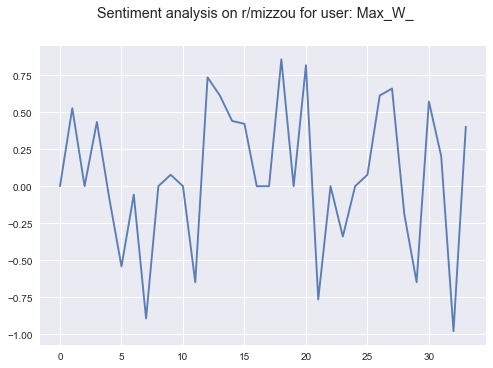

In [44]:
plotSentiment("Max_W_", "mizzou", r)

Retrieved 2838 comments for user: BrettGilpin


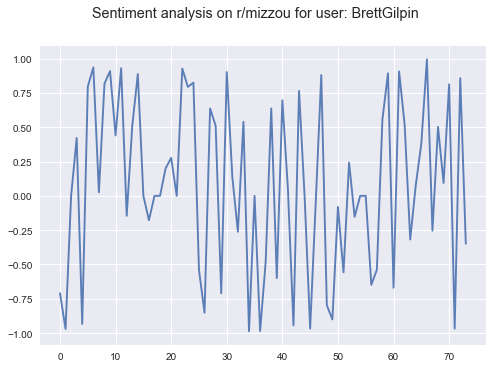

In [45]:
plotSentiment("BrettGilpin", "mizzou", r)

Retrieved 1510 comments for user: EveryTrueSon


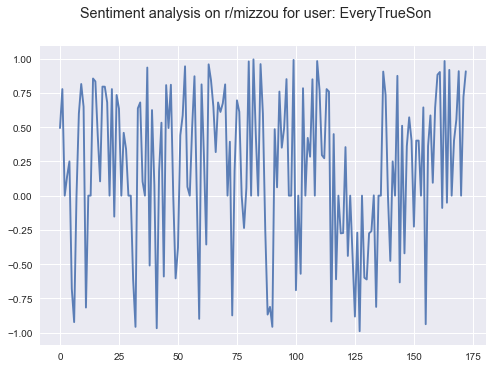

In [46]:
plotSentiment("EveryTrueSon", "mizzou", r)

Retrieved 1620 comments for user: Apatches


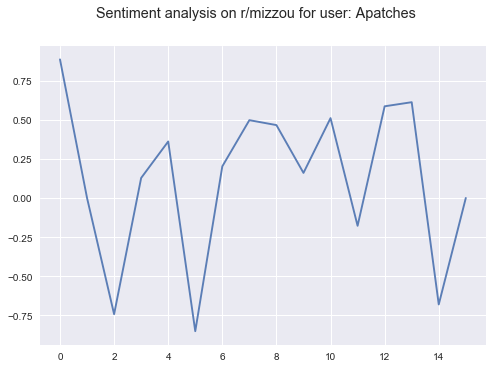

In [47]:
plotSentiment("Apatches", "mizzou", r)

In [48]:
plotSentiment("BransonBombshell", "mizzou", r)

Retrieved 1987 comments for user: BransonBombshell
User has not posted on this subreddit


Retrieved 2052 comments for user: SovreignTripod


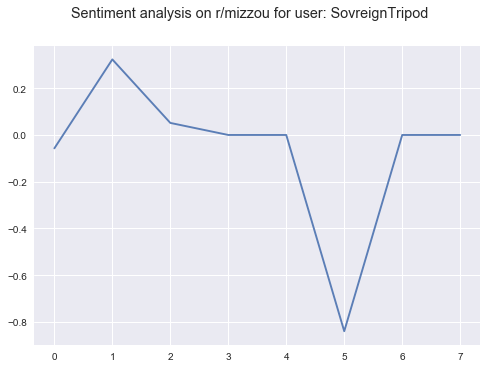

In [49]:
plotSentiment("SovreignTripod", "mizzou", r)

Retrieved 2420 comments for user: Max_W_


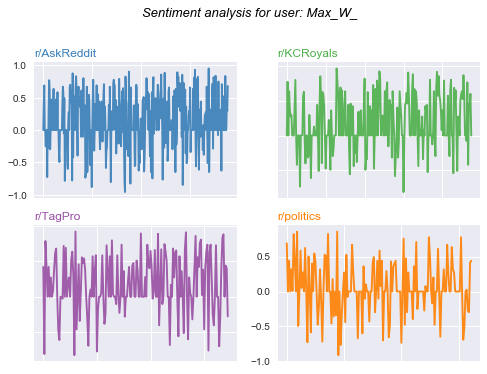

In [50]:
plotTopSentiments("Max_W_", r)

Retrieved 2838 comments for user: BrettGilpin


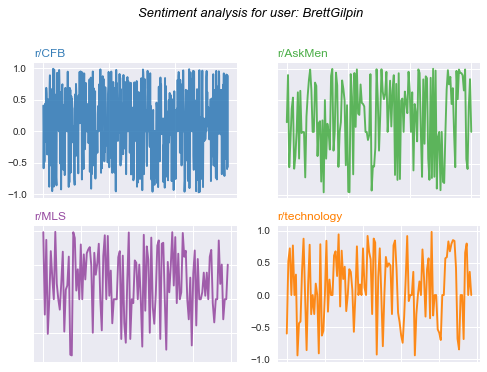

In [51]:
plotTopSentiments("BrettGilpin", r)

Retrieved 1510 comments for user: EveryTrueSon


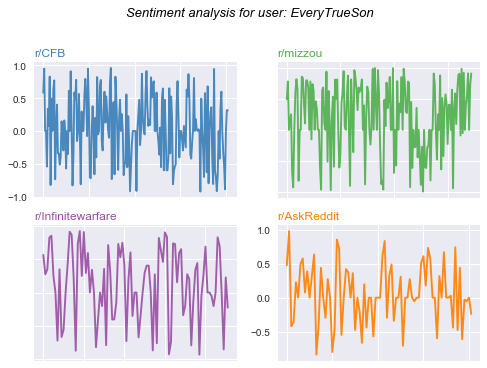

In [52]:
plotTopSentiments("EveryTrueSon", r)

Retrieved 1620 comments for user: Apatches


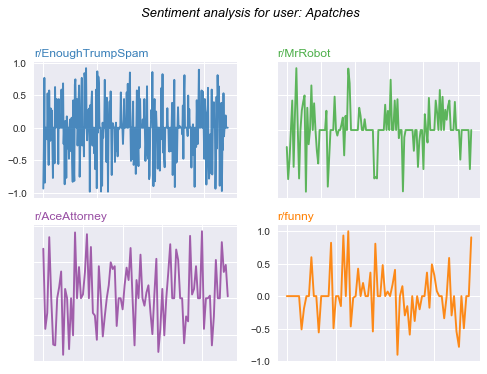

In [53]:
plotTopSentiments("Apatches", r)

Retrieved 1987 comments for user: BransonBombshell


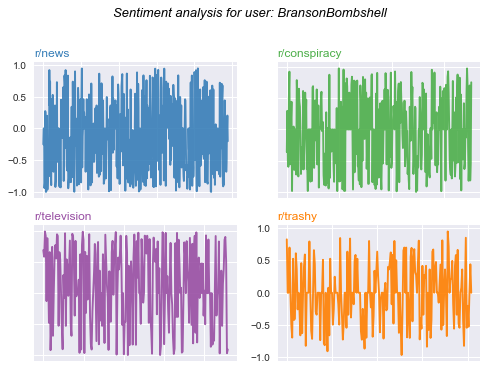

In [54]:
plotTopSentiments("BransonBombshell", r)

Retrieved 2052 comments for user: SovreignTripod


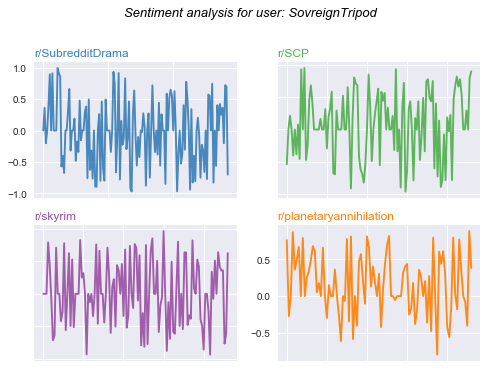

In [55]:
plotTopSentiments("SovreignTripod", r)

In [56]:
# NOTE: plot a cumulative chart of sentiment

## Build collapsible index visualization

In [57]:
def formatToDict(name, size):    
    return {'name': name, 'size': round(size*100000)}

In [58]:
def buildCollapsible(your_username, subreddit_name, redditInstance):
    matches = list(findMatches(your_username, subreddit_name, redditInstance))
    
    if (len(matches) < 1): 
        return None
    
    entireObjDict = {}
    entireObjDict["name"] = "Top Features"
    objList = []
    
    for username in matches:
        colNames = ["name", "size"]
        features = getTopFeatures(username, redditInstance)        
        features.columns = colNames
        features = features.head(15)
        
        children = list(features.apply(lambda row: formatToDict(row["name"], row["size"]), axis = 1))
        children
        
        userObj = {}
        userObj["name"] = username
        userObj["children"] = children
        objList.append(userObj)
        
    entireObjDict["children"] = objList        
    return(entireObjDict)        

In [59]:
#jsonObj = buildCollapsible("Max_W_", "mizzou", r)

## Hierarchical document clustering

In [95]:
def buildDendo(your_username, subreddit_name, redditInstance, top_n = 50):
    corpus = createCorpus(your_username, subreddit_name, r)
    corpus = corpus[0:top_n]
    print("Corpus Records:", len(corpus))
    
    matrix = createTfidfMatrix(corpus)
    print("Matrix Shape:", matrix.shape)
    
    dist = 1 - cosine_similarity(matrix)
    print("Distance Shape:", dist.shape)
    
    corpusDf = getDf(subreddit_name)
    corpusDf = corpusDf.head(top_n - 1)
    
    usernames = list(corpusDf["Username"])
    usernames.insert(0, your_username)
    print("Number of usernames:", len(usernames))
    
    for index, score in find_similar(matrix, 0):        
        index = index - 1 # because we prepended our comments onto the corpus, the index number was shifted by 1.
        user = corpusDf.iloc[index, 0]
        print("...")
        print("...")
        print("Username:", user, "| Score:", score)
        print("=========================================================")
          
    linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

    fig, ax = plt.subplots(figsize=(15, 20)) # set size
    ax = dendrogram(linkage_matrix, orientation="right", labels = usernames);

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')

    plt.tight_layout() #show plot with tight layout

    #uncomment below to save figure
    plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
          
    return(plt)

--- Retrieved 288 corpuses for r/ mizzou
------ Stemming the words
------ Retrieved 1875 comments for: Max_W_
------ Stemming the words
Corpus Records: 20
--- Creating Tfidf vectorizor...
--- Fitting the matrix...
Matrix Shape: (20, 5801)
Distance Shape: (20, 20)
--- Retrieved 288 corpuses for r/ mizzou
Number of usernames: 20
...
...
Username: YouKnowThatOtherGuy | Score: 0.548391995608
...
...
Username: WorseThanHipster | Score: 0.513130879048
...
...
Username: pisspoordecisions | Score: 0.481092662036
...
...
Username: seslor | Score: 0.478670825614
...
...
Username: J_Tuck | Score: 0.443553298888
...
...
Username: sahtopi | Score: 0.384828738617


<module 'matplotlib.pyplot' from 'C:\\Users\\Jacky Zhao\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

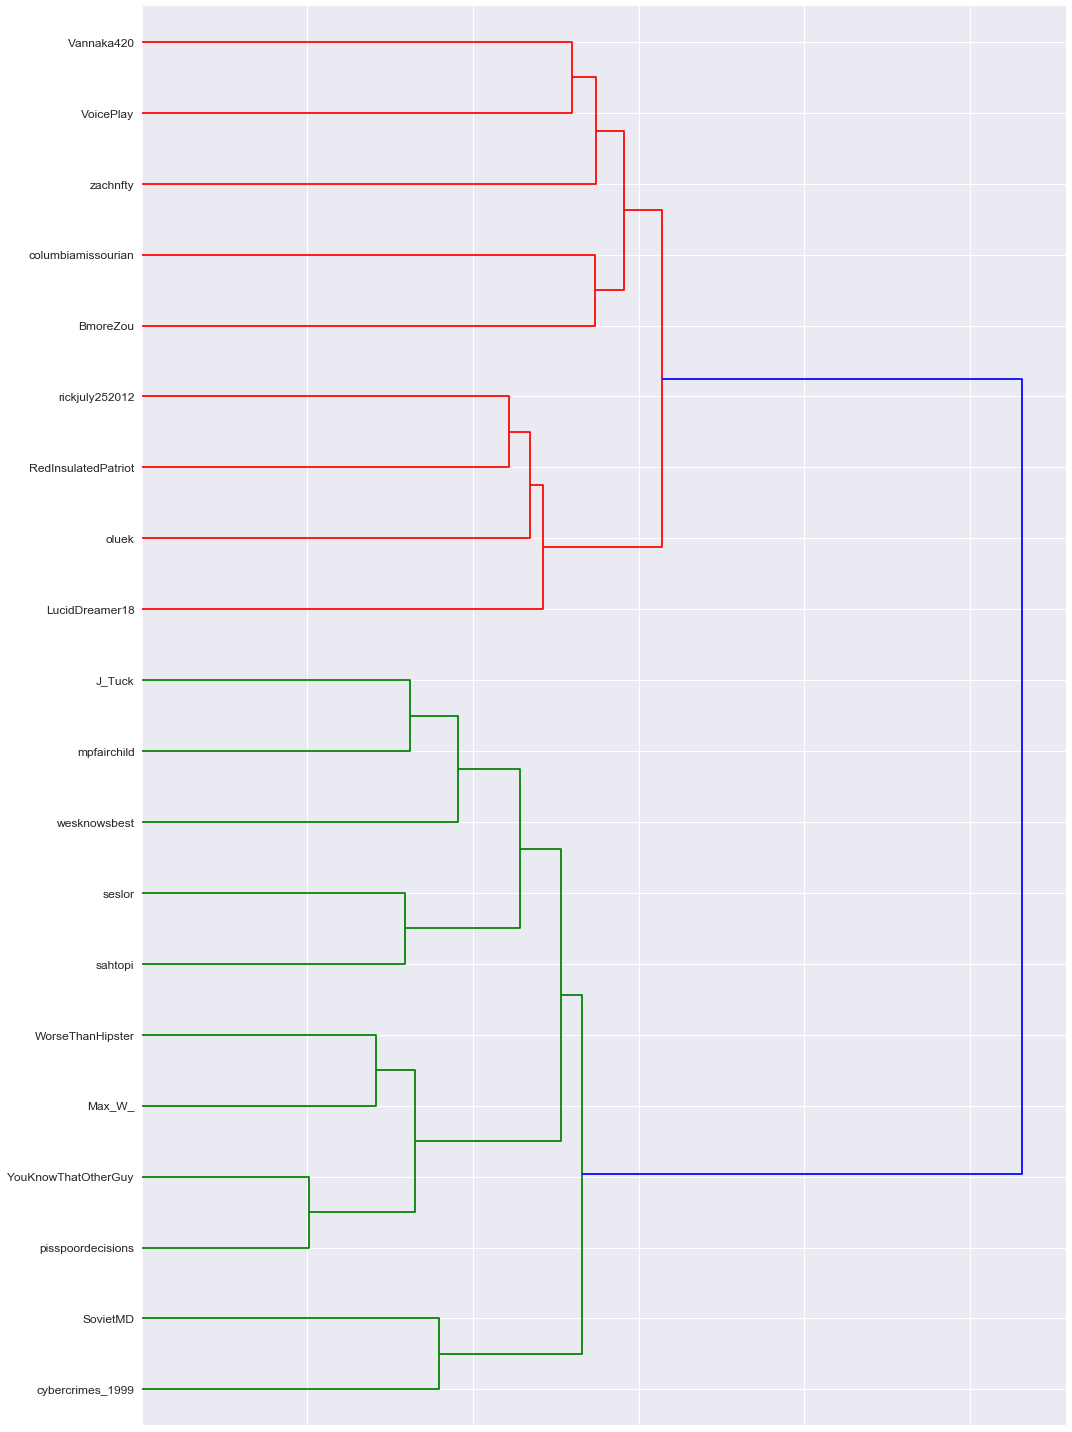

In [96]:
buildDendo("Max_W_", "mizzou", r, 20)